In [1]:
import seaborn as sns
import pandas as pd
import re
import matplotlib as mpl
from matplotlib import rc
import missingno as msno
import warnings
import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings('ignore')

# matplotlib 한글 사용을 위한 코드
rc('font', family='AppleGothic')

In [2]:
final_df = pd.read_csv(
    '../../final_df_13/final_df_13.csv').drop(columns='Unnamed: 0')
X_train = pd.read_csv(
    '../../final_df_13/X_train_13.csv').drop(columns='Unnamed: 0')
y_train = pd.read_csv(
    '../../final_df_13/y_train_13.csv').drop(columns='Unnamed: 0')
X_test = pd.read_csv(
    '../../final_df_13/X_test_13.csv').drop(columns='Unnamed: 0')
y_test = pd.read_csv(
    '../../final_df_13/y_test_13.csv').drop(columns='Unnamed: 0')

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 925 non-null    object 
 1   director              925 non-null    object 
 2   distributor           925 non-null    object 
 3   distributor_group     925 non-null    object 
 4   release_date          925 non-null    int64  
 5   release_season        925 non-null    object 
 6   release               925 non-null    object 
 7   form                  925 non-null    object 
 8   nation                925 non-null    object 
 9   screen                925 non-null    int64  
 10  rev_nationwide        925 non-null    float64
 11  aud_nationwide        925 non-null    int64  
 12  rev_seoul             925 non-null    int64  
 13  rev_seoul.1           925 non-null    int64  
 14  genre                 925 non-null    object 
 15  rate                  9

In [4]:
len(X_train), len(X_test), len(y_train), len(y_test),

(740, 185, 740, 185)

In [5]:
df = pd.concat([X_train, y_train], axis=1)

In [6]:
df.head(1)

,title,director,distributor,distributor_group,release_date,release_season,release,form,nation,screen,...,actor_power,director_count,director_movie_count,actor_movie_count,before_news,after_news,holiday,dist_cat,aud_nationwide,log_aud
0,인사이드 아웃,피트 닥터,월트디즈니컴퍼니코리아(주),B,20150709,summer,개봉영화,장편,미국,777,...,0,1,0,0,67.0,352.0,0,B,4968687,15.418666


In [7]:
len(df.columns)

35

In [8]:
df = df.drop(columns=['distributor_group', 'release', 'form',
                      'rev_nationwide', 'rev_seoul', 'rev_seoul.1', 'director_count'])

In [9]:
len(df.columns)

29

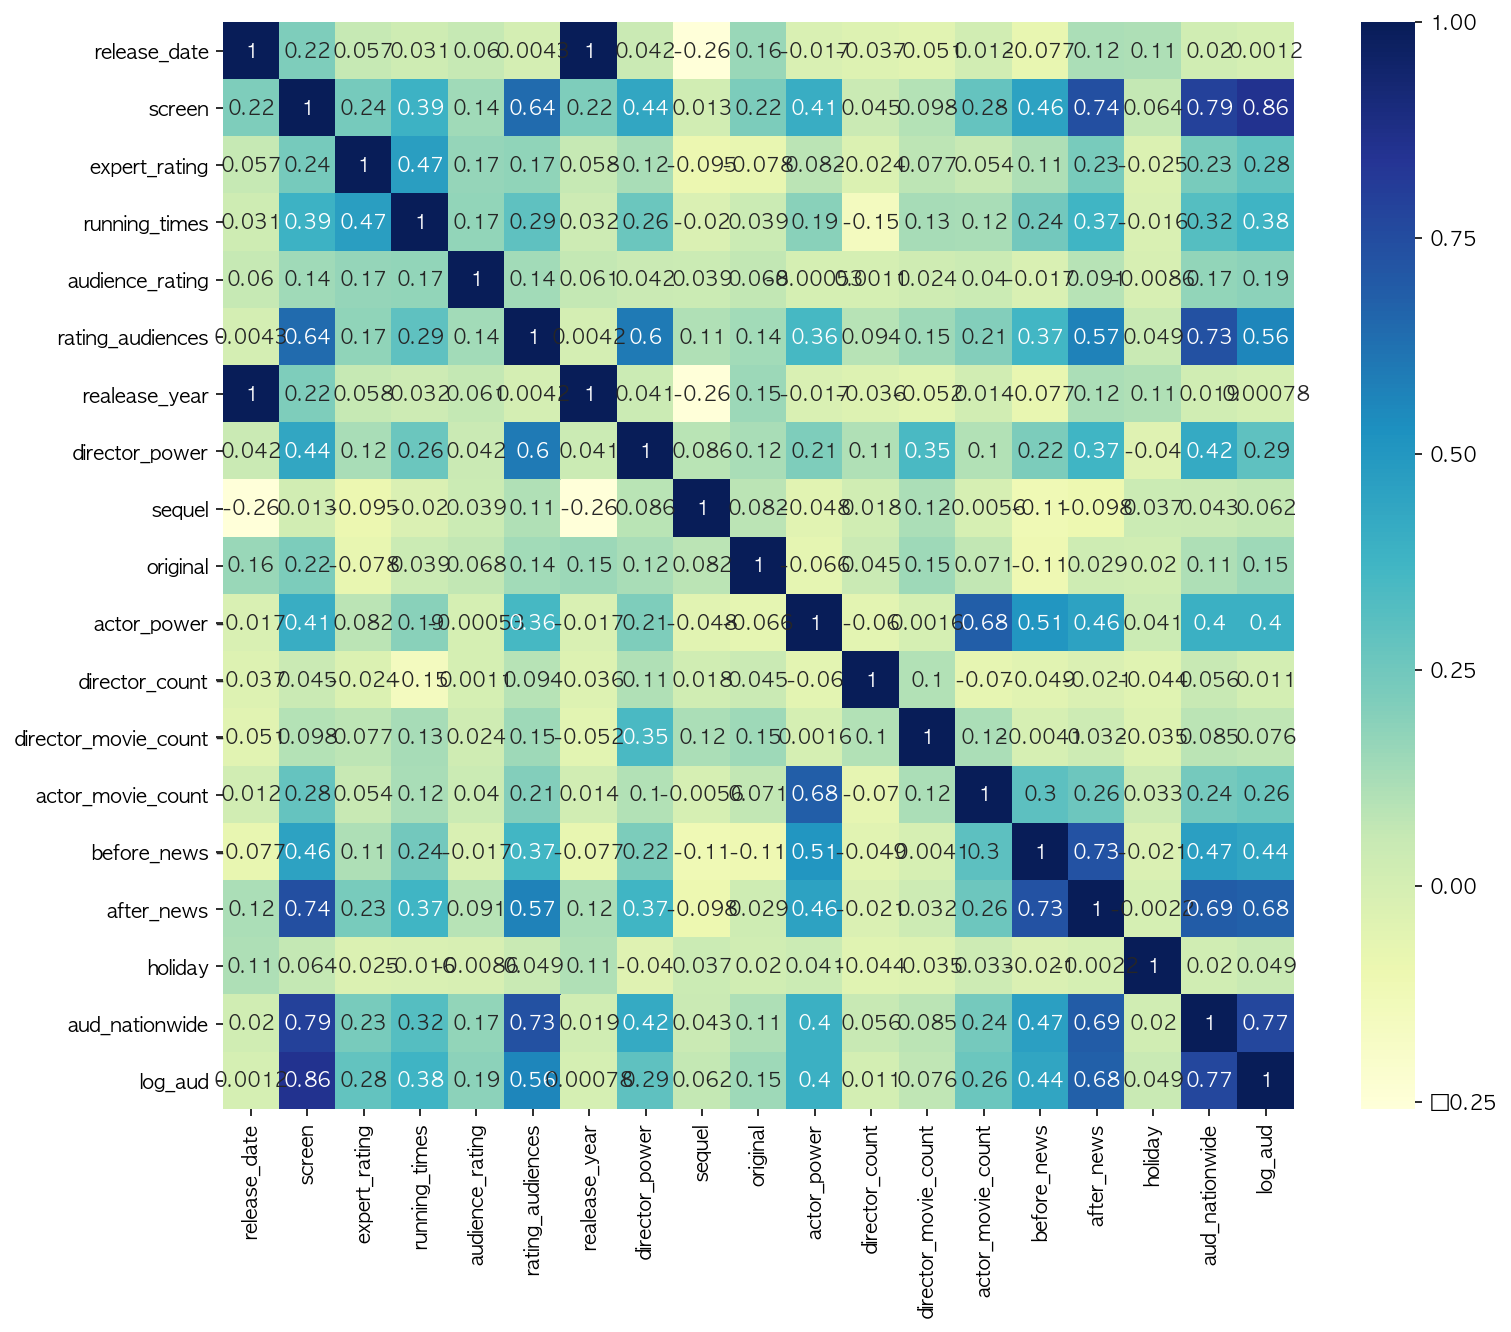

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="YlGnBu")

plt.show()

In [13]:
df.columns

Index(['title', 'director', 'distributor', 'release_date', 'release_season',
       'nation', 'screen', 'genre', 'rate', 'type', 'expert_rating',
       'starring_actors', 'running_times', 'audience_rating',
       'rating_audiences', 'realease_year', 'director_power', 'sequel',
       'original', 'actor_power', 'director_count', 'director_movie_count',
       'actor_movie_count', 'before_news', 'after_news', 'holiday', 'dist_cat',
       'aud_nationwide', 'log_aud'],
      dtype='object')

In [17]:
kfold_dict = {}
kfold_dict_avr = []
kfold_df = pd.DataFrame()

# model0

In [18]:
df0 = df.copy()

In [19]:
# 19개의 독립변수 사용

feature_names = ['screen', 'expert_rating', 'audience_rating', 'running_times',
                 'rating_audiences', 'director_power', 'actor_power', 'before_news', 'after_news', 'director_movie_count', 'actor_movie_count']
feature_names = ["scale({})".format(name) for name in feature_names] + ['dist_cat',
                                                                        'release_season', 'nation', 'genre', 'rate', 'C(sequel)', 'C(original)', 'C(holiday)']
model0 = sm.OLS.from_formula(
    "aud_nationwide ~" + "+".join(feature_names), data=df0)
result0 = model0.fit()
print(result0.summary())

                            OLS Regression Results                            
Dep. Variable:         aud_nationwide   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     51.50
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          4.73e-180
Time:                        17:58:37   Log-Likelihood:                -11288.
No. Observations:                 740   AIC:                         2.266e+04
Df Residuals:                     699   BIC:                         2.285e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [20]:
# kfold 0

from sklearn.model_selection import KFold

kfold_dict['0'] = []
scores = np.zeros(10)
cv = KFold(10, shuffle=True, random_state=0)
for i, (idx_train, idx_test) in enumerate(cv.split(df0)):
    df_train = df0.iloc[idx_train]
    df_test = df0.iloc[idx_test]

    model = sm.OLS.from_formula(
        "log_aud ~" + "+".join(feature_names), data=df_train)
    result = model.fit()

    pred = result.predict(df_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                                   'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
    rss = ((df_test['log_aud'] - pred) ** 2).sum()
    tss = ((df_test['log_aud'] - df_test['log_aud'].mean()) ** 2).sum()
    rsquared = 1 - rss/tss

    scores[i] = rsquared
    kfold_dict['0'].append(rsquared)
    print("학습 R2 = {:.8f}, 검증 R2 = {:.8f}".format(result.rsquared, rsquared))

kfold_dict_avr.append(sum(kfold_dict['0'])/10)

PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: NameError: name 'director_movie_count' is not defined
    log_aud ~scale(screen)+scale(expert_rating)+scale(audience_rating)+scale(running_times)+scale(rating_audiences)+scale(director_power)+scale(actor_power)+scale(before_news)+scale(after_news)+scale(director_movie_count)+scale(actor_movie_count)+dist_cat+release_season+nation+genre+rate+C(sequel)+C(original)+C(holiday)
                                                                                                                                                                                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [ ]:
# model0의 테스트 R

pred = result0.predict(X_test[['screen', 'expert_rating', 'audience_rating', 'running_times', 'rating_audiences', 'director_power',
                               'actor_power', 'before_news', 'after_news', 'dist_cat', 'release_season', 'nation', 'genre', 'rate', 'sequel', 'original']])
rss = ((y_test['aud_nationwide'] - pred) ** 2).sum()
tss = ((y_test['aud_nationwide'] - y_test['aud_nationwide'].mean()) ** 2).sum()
rsquared = 1 - rss/tss
rsquared